### continuation of 011

### setup

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
# from tqdm.contrib.concurrent import process_map

In [2]:
def apply_amat(acid,acid_match,amine,amine_match,rmat):
    """
    needs the smarts of the acid and amine pre-defined. maybe an external dictionary.
    """
    # combine molecules and make a writable version
    both = Chem.CombineMols(acid,amine)
    bothW = Chem.RWMol(both)
    Chem.Kekulize(both,clearAromaticFlags=True)
    Chem.Kekulize(bothW,clearAromaticFlags=True)
    # get the indices for the acid and amine matches.
    amine_atoms = both.GetSubstructMatch(group_dict[amine_match])
    acid_atoms = both.GetSubstructMatch(group_dict[acid_match])
    
    if not (amine_atoms and acid_atoms):
        print("substruct match not found")
        return
    
    # join the indices
    atom_list = amine_atoms + acid_atoms
    
    # go through the amat to find places where the change is not 0
    side_len = len(rmat)
    
    if side_len != len(atom_list):
        print("matrix length does not equal number of matched atoms")
        return
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order_change = rmat[r][c]
            if bond_order_change != 0: 
                atom1 = atom_list[amat2ind[r]]
                atom2 = atom_list[amat2ind[c]]
                # get the current bond order
                current_bond = both.GetBondBetweenAtoms(atom1,atom2)
                if current_bond: 
                    current_bond_order = current_bond.GetBondTypeAsDouble()
                    
                else: 
                    current_bond_order = 0
                new_bond_order = current_bond_order + bond_order_change
                
                if new_bond_order not in [0,1,2,3]:

                    return None
                # make bond changes
                
                bothW.RemoveBond(atom1,atom2)
                
                if new_bond_order > 0:
                    bothW.AddBond(atom1,atom2, bond_dict[new_bond_order])

                        
    try:
        Chem.SanitizeMol(bothW)

    except:
#         print("illegal structure")
        return None
    return bothW

### encode basic acid and amine

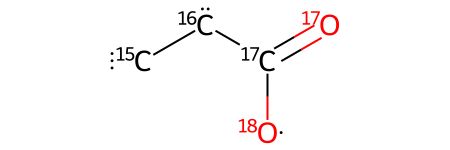

In [3]:
sp3_acid_smiles = '[17O]=[17C]([18O])[16C][15C]'
basic_acid = Chem.MolFromSmiles(sp3_acid_smiles)
basic_acid

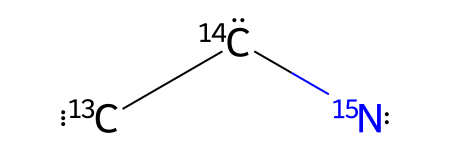

In [4]:
sp3_amine_smiles = "[15N][14C][13C]"
basic_amine = Chem.MolFromSmiles(sp3_amine_smiles)
basic_amine

In [5]:
am2 = Chem.MolFromSmarts("[CX3]=[CX3][NH2]")
ac2 = Chem.MolFromSmarts("[CX3][CX3][CX3](=O)[OX2H1]")
am3 = Chem.MolFromSmarts("[13C][14C][15N]")
ac3 = Chem.MolFromSmarts("[15C][16C][17C](=[17O])[18O]")

group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}

# make a mapping dictionary.
# the dictionary is basically, first entry is amine C1. second entry is amine C2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
mapping_order = [0,1,3,4,5,2,6,7]
# mapping_order = [3,4,5,0,1,2,6,7]

# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, mapping_order)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}

### check that the substruct matching hits the right region

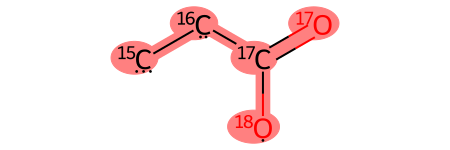

In [6]:
basic_acid.GetSubstructMatch(ac3)
basic_acid

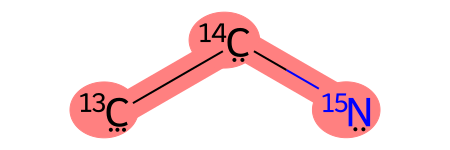

In [7]:
basic_amine.GetSubstructMatch(am3)
basic_amine

### read data file from coupling the larger molecules

In [8]:
large_data = pd.read_csv("./ac3drug_am3small/ac3drug_am3small_smiles.csv")

In [9]:
valid_rmat_inds = np.array(list(large_data.rmat_tag))
valid_rmat_inds.sort()

In [10]:
large_data.sort_values("rmat_tag",inplace=True)
large_data.head(3)

,rmat_tag,distance,largest_frag,largest_cleaned
8745,41194,6.0,[15N][17O][17C]([16CH]c1ccc(N2Cc3c(F)cccc3C2=O...,NOC(Cc1ccc(N2Cc3ccccc3C2=O)cc1)OCc1ccccc1
10741,41213,6.0,[15N][17C]([17O])([16CH]c1ccc(N2Cc3c(F)cccc3C2...,NC(O)(Cc1ccc(N2Cc3ccccc3C2=O)cc1)OCc1ccccc1
10742,41316,6.0,[15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17C...,N[C@H](c1ccc(N2Cc3ccccc3C2=O)cc1)C(O)OCc1ccccc1


### compile which parts of the 8-atom reaction center are in the coupled product

In [11]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

frags = []
for s in tqdm(list(large_data.largest_frag)):
    frags.append([i for i in acid_parts+amine_parts if i in s])
    

  0%|          | 0/14169 [00:00<?, ?it/s]

In [12]:
def run_enumeration(file_ind):
    index_start = file_ind * 1000000
    index_end = (file_ind+1) * 1000000
    
    valid_ind_locs = np.where(np.logical_and(valid_rmat_inds>= index_start,valid_rmat_inds < index_end))[0]

    # get the rmat inds needed
    rmat_inds_to_use = valid_rmat_inds[valid_ind_locs]

    # the local index for that particular file.
    rmat_inds_local = rmat_inds_to_use - file_ind * 1000000

    # rmat_inds_to_use is the true rmat_tag

    file_tag = str(file_ind).zfill(2)
    dmats = np.load(f"../rxn_mats/dmats_ac3_am3_{file_tag}.npy")
    dmats_to_use = dmats[rmat_inds_local]

    out_file = open(f"./ac3drug_am3small/rxn_center_only_{file_tag}.csv","w")
    out_file.write("rmat_tag,pdt_smiles\n")
    for i,dmat in enumerate(dmats_to_use):


    #     matrix_index = index_start + i
    #     m = apply_amat(basic_acid,"ac3",basic_amine,"am3",dmat)
    #     s = Chem.MolToSmiles(m,isomericSmiles=True)
    #     out_file.write(s+"\n")
        try:
            matrix_index = rmat_inds_to_use[i]
            m = apply_amat(basic_acid,"ac3",basic_amine,"am3",dmat)
            s = Chem.MolToSmiles(m,isomericSmiles=True)
            out_file.write(f"{matrix_index},{s}\n")

        except:
            continue

    out_file.close()


In [13]:
run_range = range(56)
# run_range = np.arange(0,56,5)

In [14]:
for i in tqdm(run_range):
    run_enumeration(i)

  0%|          | 0/56 [00:00<?, ?it/s]

### Dataframe of products from coupling the small 8-atom system, using only transformations that resulted in valid products for the functionalized druglike system

In [17]:
small_pd = pd.concat([pd.read_csv(f"./ac3drug_am3small/rxn_center_only_{str(i).zfill(2)}.csv") for i in run_range])

In [18]:
small_pd.head()

,rmat_tag,pdt_smiles
0,41194,[13C].[14C][18O][17C]([16C])[17O][15N].[15C]
1,41213,[13C].[14C][18O][17C]([16C])([15N])[17O].[15C]
2,41316,[13C].[14C][18O][17C]([17O])[16C][15N].[15C]
3,41320,[13C].[14C][18O][17C](=[17O])[16C][15N].[15C]
4,42829,[13C].[14C][18O][17C](=[17O])[16C][15N][15C]


In [19]:
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab]) 

def clean_structure(s):
    temp = s
    
    for i in acid_parts + amine_parts:
        temp = temp.replace(i,i[-2])
        
    return temp

In [20]:
relev_all = []
for i_s,s in tqdm(enumerate(small_pd.pdt_smiles)):
    split_s = s.split(".")
    
    # this is the list of tagged atoms that appear in the functionalized drug system.
    frg = frags[i_s]
    
    # find the reaction center fragment that corresponds to the drug product
    relev_part = []
    for ss in split_s:
        if any([i in ss for i in frg]):
            relev_part.append(ss)
    
    # if there's more than 1, keep the largest fragment
    if len(relev_part) > 1:
        atom_counts = [count_atoms(r) for r in relev_part]
        max_atom_ind = np.argmax(atom_counts)
        relev_part = relev_part[max_atom_ind]
    relev_all.append(relev_part[0])
            
    

0it [00:00, ?it/s]

### add and clean

In [21]:
small_pd["frag_in_large"] = relev_all

small_pd["pdt_cleaned"] = [clean_structure(s) for s in small_pd.frag_in_large]

In [22]:
small_pd.head()

,rmat_tag,pdt_smiles,frag_in_large,pdt_cleaned
0,41194,[13C].[14C][18O][17C]([16C])[17O][15N].[15C],[14C][18O][17C]([16C])[17O][15N],COC(C)ON
1,41213,[13C].[14C][18O][17C]([16C])([15N])[17O].[15C],[14C][18O][17C]([16C])([15N])[17O],COC(C)(N)O
2,41316,[13C].[14C][18O][17C]([17O])[16C][15N].[15C],[14C][18O][17C]([17O])[16C][15N],COC(O)CN
3,41320,[13C].[14C][18O][17C](=[17O])[16C][15N].[15C],[14C][18O][17C](=[17O])[16C][15N],COC(=O)CN
4,42829,[13C].[14C][18O][17C](=[17O])[16C][15N][15C],[14C][18O][17C](=[17O])[16C][15N][15C],COC(=O)CNC


In [26]:
small_pd.to_csv("./ac3drug_am3small/ac3drug_am3small_rxn_centers.csv",index=False)